### Shocks to Inflation

This notebook constructs all shocks to inflation used to explore conditional responses of inflation expectations

- Oil shocks: Hamilton (1996) （no need for SVAR)
- Technology shocks: Gali(1999)
- News shocks: Sims et al.(2014)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
from numpy import linalg as LA
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, SVAR
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from statsmodels.tsa.vector_ar.irf import BaseIRAnalysis
from statsmodels.tsa.base.datetools import dates_from_str
import statsmodels.tsa.vector_ar.plotting as plotting

from scipy.stats import pearsonr as prs

### Structural VAR with long-run restrictions (Gali (1999))

A vector of variables: $\Delta x_t$, $\Delta n_t$ and $\pi_t$

$$\left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] = \left[\begin{array} \\ C(L)_{11}, C(L)_{12}, C(L)_{13} \\ C(L)_{21}, C(L)_{22}, C(L)_{23} \\ C(L)_{31}, C(L)_{32}, C(L)_{33} \end{array}  \right]   \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

Identification restriction is 

- Orthogonality + normalization: $E(\epsilon \epsilon')= I$   
- $C(1)_{12}=0$
- $C(1)_{13}=0$
- $C(1)_{23}=0$

Then $C(L)$ is lower triangluar and just identified. This is so called long-run restrictions from Blanchard and Quah (1989). 

Rewriting it into a general form of SVAR, we have  

$$A(L) \left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] =\left[\begin{array} \\ u_t^z \\ u^m_t \\ u^\pi_t  \end{array}\right]  =B \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

where $u_t$ is reduced form residul and $\epsilon_t$ is structural shock. 


$$\left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] =A(L)^{-1} B \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] = \mathbf{C}(L) \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

With $p$ lags, we have $$A(L) = I_k - A_1L - A_2L^2-\ldots - A_pL^p$$

The estimation takes following stepss. 

1. Estimate OLS to get estimates $\hat A_1, \hat A_2, \ldots, \hat A_p$ and $\hat \Sigma^u$.

2. Use the following to sovle $\hat B$, $$(I_k - \hat A_1 - \ldots - \hat A_p)^{-1} \hat B = Col((I_k - \hat A_1 - \ldots - \hat A_p)\hat \Sigma^u(I_k - \hat A'_1 - \ldots - \hat A'_p)^{-1})$$ 

The existing SVAR package in *statsmodels* only handles cases with direct zero restrictions on $B$ matrices. Therefore I write my own codes using long-run restrictions here.  

In [2]:
## technology shock data
ts_data = pd.read_excel('../OtherData/Emp.xls',sheet_name='data')
ts_data['observation_date'] = pd.to_datetime(ts_data['observation_date'],format='%Y%m%d')

## dates 
datesQ = ts_data['observation_date'].dt.year.astype(int).astype(str) + \
         "Q" + ts_data['observation_date'].dt.quarter.astype(int).astype(str)
datesQ = dates_from_str(datesQ)


## inflation data (monthly to quarterly)
inf_dataM = pd.read_stata('../OtherData/InfM.dta')
filterQ = inf_dataM['month'].isin([3,6,9,12])
inf_dataQ = inf_dataM[filterQ]
infQ = inf_dataQ['CPIAU'].pct_change()
inf_datesQ = inf_dataQ['date'].dt.year.astype(int).astype(str) + \
             "Q" + inf_dataQ['date'].dt.quarter.astype(int).astype(str)
inf_datesQ = dates_from_str(inf_datesQ)

In [3]:
# set date index to productivity and labor series
ts_var1 = ts_data[['DLPROD1','DLHOURS']]
ts_var2 = ts_data[['DLPROD2','DLEMP']]

ts_var1.index = pd.DatetimeIndex(datesQ,freq='Q')
ts_var2.index = pd.DatetimeIndex(datesQ,freq='Q')

# set date index to inf series 
infQ.index= pd.DatetimeIndex(inf_datesQ)

In [4]:
## merge with inflation
# order of vector for var:  [productivity, labor input, inflation]
#ts_var1 = pd.concat([ts_var1,infQ], join='inner', axis=1)
#ts_var2 = pd.concat([ts_var2,infQ], join='inner', axis=1)

ts_var1=ts_var1.copy().dropna()
ts_var2=ts_var2.copy().dropna()

In [5]:
# period filter 
start_t='1948-01-01'
end_t = '1994-12-30'

ts_var1=ts_var1.copy().loc[start_t:end_t]
ts_var2=ts_var2.copy().loc[start_t:end_t]

# Estimate reduced VAR 
model1 = VAR(ts_var1)  # var model with no restriction
model2 =VAR(ts_var2)   # var model2 with no restriction


#svmodel1=SVAR(ts_var1.loc[start_t:end_t],svar_type='B',\
 #             B=np.array([['E',0,0],['E','E',0],['E','E','E']]))  # svar model with restriction
#svmodel2=SVAR(ts_var2.loc[start_t:end_t],svar_type='B',\
              # B=np.array([['E',0],['E','E']]))  # svar model with restriction

In [23]:
## Checks the data 

## Pearson test of correlation 
prs1_pval=prs(ts_var1.iloc[:,0],ts_var1.iloc[:,1])[1]
prs2_pval=prs(ts_var2.iloc[:,0],ts_var2.iloc[:,1])[1]

print('Model1')
print('Sample mean:\n'+str(ts_var1.mean()))
print('Correlation coefficients of series\n'+str(ts_var1.corr()))
print('The p-value of Pearson Test of the Correlation is '+str(round(prs1_pval,3)))

print('Model2')
print('Sample mean:\n'+str(ts_var2.mean()))
print('Correlation coefficients of series\n'+str(ts_var2.corr()))
if prs2_pval !='NaN':
    print('The p-value of Pearson Test of the Correlation is '+str(round(prs2_pval,3)))

Model1
Sample mean:
DLPROD1    0.002180
DLHOURS    0.001583
dtype: float64
Correlation coefficients of series
          DLPROD1   DLHOURS
DLPROD1  1.000000 -0.248596
DLHOURS -0.248596  1.000000
The p-value of Pearson Test of the Correlation is 0.001
Model2
Sample mean:
DLPROD2   NaN
DLEMP     NaN
dtype: float64
Correlation coefficients of series
         DLPROD2  DLEMP
DLPROD2      NaN    NaN
DLEMP        NaN    NaN
The p-value of Pearson Test of the Correlation is nan


In [25]:
rs1=model1.fit(ic='aic')
#rs2=model2.fit(ic='aic')
#srs1=svmodel1.fit(4)
#srs2=svmodel2.fit(4,solver='nm')

In [26]:
rs1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, May, 2019
Time:                     11:36:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -22.8082
Nobs:                     185.000    HQIC:                  -22.9117
Log likelihood:           1610.85    FPE:                1.04459e-10
AIC:                     -22.9823    Det(Omega_mle):     9.90334e-11
--------------------------------------------------------------------
Results for equation DLPROD1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.002539         0.000357            7.109           0.000
L1.DLPROD1        -0.066617         0.073587           -0.905           0.365
L1.DLHOURS        -0.110982         0.067665           -1.640         

In [27]:
## define function of Blanchard and Quah long-run restriction

def SVAR_BQLR(rs):
    """
    inputs
    ------
    rs: result object of reduced VAR estimated using statsmodels.tsa.VAR
    
    outputs
    -------
    dictionary:
      sigma_u: ndarrray
               variance-convariance of reduced VAR residuals 
      B_est:   ndarray
               estimated B matrices using long-run restrictions
      eps_est: ndarray
               estimated structural shocks
      A_L:     ndarray
               I_k - A_1 - \ldots -A_p
      C_L:     adarray 
               A_L.inv * B
      nlags:   int
               number of lags 
      residuals: ndarray
               reduced var residuals 
      ...
    """

    k = rs1.neqs    # number of equations 
    nlags =rs1.coefs.shape[0] # number of lags 
    sigma_u = rs1.sigma_u 
    #print('Var-covariance matrix of reduced-form VAR is \n'+str((sigma_u)))
    ## Estimate B matrices 
    I_k = np.ones(k)
    var_coefs=rs1.coefs   # p x k x k 
    A_L = I_k
    A_L_prime = I_k
    for i in range(len(var_coefs)):
        #print(A_L)
        A_L = A_L - var_coefs[i,:,:]
        #print(A_L_prime)
        A_L_prime = A_L_prime - var_coefs[i,:,:].T
        
        B_svar_est = np.dot(A_L,LA.cholesky(
            np.dot(
                np.dot(LA.inv(A_L),
                       sigma_u),
                LA.inv(A_L_prime))
        )
                           )
        #print('Estimated B matrice is \n'+str(B_svar_est))
        ## check if the restrictions hold
        
        C_L=np.dot(LA.inv(A_L),B_svar_est)
        if np.allclose(C_L, np.tril(C_L)):
            print('C_L is indeed lower triangular, consistent with long-run restriction')
        else:
            print('Something is wrong: C_L is not lower triangular, inconsistent with long-run restriction')

        
        ## structural shocks 
        u = np.array(rs1.resid)
        epsilon_est = np.dot(LA.inv(B_svar_est),(np.array(rs1.resid).T))
          
        ## impulse response 
        #IR_svar = np.kron(var_coefs,B_svar_est)
        #print(IR_svar.shape)
        
        return {'var_coefs':var_coefs,'sigma_u':sigma_u,'B_est':B_svar_est,\
                'eps_est':epsilon_est,'A_L':A_L,'C_L':C_L,'nlags':nlags, 'neqs': k,\
                'residuals':u}

In [28]:
### Invokes BQLR 

SVAR_rst = SVAR_BQLR(rs1)
var_coefs_est,A_L,C_L,sigma_u,B_svar_est,epsilon_est,nlags,neqs,residuals = (SVAR_rst['var_coefs'],SVAR_rst['A_L'],\
                                                                             SVAR_rst['C_L'],SVAR_rst['sigma_u'], \
                                                                             SVAR_rst['B_est'],SVAR_rst['eps_est'],\
                                                                             SVAR_rst['nlags'],SVAR_rst['neqs'],\
                                                                             SVAR_rst['residuals'])

C_L is indeed lower triangular, consistent with long-run restriction


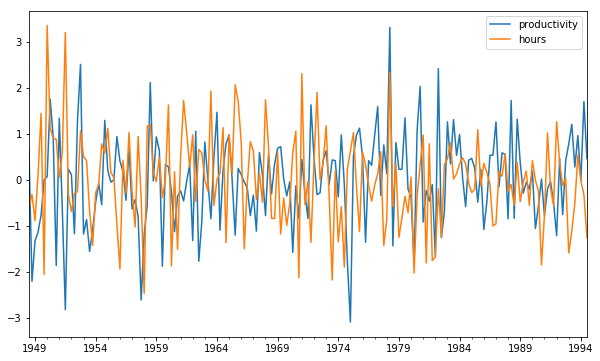

In [29]:
## Look into the structural shocks epsilon

str_shocks_est=pd.DataFrame(epsilon_est.T)
str_shocks_est.index=ts_var1.index[nlags:]
if str_shocks_est.shape[1]==3:
    str_shocks_est.columns=['productivity','hours','inflation']
if str_shocks_est.shape[1]==2:
    str_shocks_est.columns=['productivity','hours']
#str_shocks_est.columns=['productivity','hours','inflation']
str_shocks_est.plot(figsize=(10,6))
str_shocks_est.to_stata('../OtherData/TechInfShocks.dta')

In [30]:
def ma_rep(coefs, maxn=10):
    """
    MA(\infty) representation of VAR(p) process
    Parameters
    ----------
    coefs : ndarray (p x k x k)
    maxn : int
        Number of MA matrices to compute
    Notes
    -----
    VAR(p) process as
    .. math:: y_t = A_1 y_{t-1} + \ldots + A_p y_{t-p} + u_t
    can be equivalently represented as
    .. math:: y_t = \mu + \sum_{i=0}^\infty \Phi_i u_{t-i}
    e.g. can recursively compute the \Phi_i matrices with \Phi_0 = I_k
    Returns
    -------
    phis : ndarray (maxn + 1 x k x k)
    """
    p, k, k = coefs.shape
    phis = np.zeros((maxn+1, k, k))
    phis[0] = np.eye(k)
    # recursively compute Phi matrices
    for i in range(1, maxn + 1):
        for j in range(1, i+1):
            if j > p:
                break
                
            phis[i] += np.dot(phis[i-j], coefs[j-1])
    return phis

# 
T_irf = 5 
# compute impulse responses 
ma_mats = ma_rep(var_coefs_est,maxn=T_irf)  

A_svar_est = np.eye(neqs)   # A is identity matrix by assumption
P = np.dot(LA.inv(A_svar_est), B_svar_est) 

## ma_rep to svar_ma_rep

svar_ma_rep = np.array([np.dot(coefs, P) for coefs in ma_mats])  # T+1 x k x k 


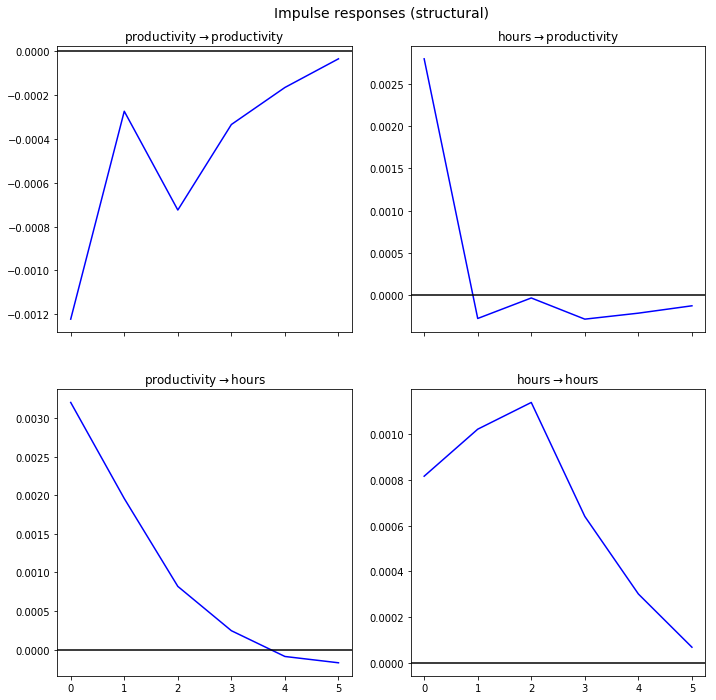

In [31]:
## IR plot parameters prepared 

## svar_ma to impulse respulse parameters

irfs = svar_ma_rep 

stderr = None  # T x k x k

impulse = None  # 

response =  None  #

if neqs==3:
    model_names= np.array(['productivity','hours','inflation'])
if neqs==2:
    model_names= np.array(['productivity','hours'])

title = 'Impulse responses (structural)'

signif =0.05

subplot_params =None

stderr_type ='asym'

plot_params={}

import statsmodels.tsa.vector_ar.plotting as plotting


fig = plotting.irf_grid_plot(irfs, stderr, impulse, response,
                                     model_names, title, signif=signif,
                                     subplot_params=subplot_params,
                                     plot_params=plot_params,
                                     stderr_type=stderr_type)

In [35]:
## replicate Gali(1999) figure 1

"""
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(ts_var1.iloc[:,1],ts_var1.iloc[:,0])
plt.xlabel('hours')
plt.ylabel('productivity')

plt.subplot(1,3,2)
plt.scatter(residuals[:,1],str_shocks_est['productivity'])
plt.xlabel('hours')
plt.ylabel('technology shocks')

plt.subplot(1,3,3)
plt.scatter(residuals[:,1],str_shocks_est['hours'])
plt.xlabel('hours')
plt.ylabel('non-technology shocks')
"""

"\nplt.figure(figsize=(15,5))\n\nplt.subplot(1,3,1)\nplt.scatter(ts_var1.iloc[:,1],ts_var1.iloc[:,0])\nplt.xlabel('hours')\nplt.ylabel('productivity')\n\nplt.subplot(1,3,2)\nplt.scatter(residuals[:,1],str_shocks_est['productivity'])\nplt.xlabel('hours')\nplt.ylabel('technology shocks')\n\nplt.subplot(1,3,3)\nplt.scatter(residuals[:,1],str_shocks_est['hours'])\nplt.xlabel('hours')\nplt.ylabel('non-technology shocks')\n"

In [96]:
#ts_plot1=rs1.plot()

In [29]:
"""
print('Reduced VAR ir Plot')
irf1 = rs1.irf(10)
ir_plot1=irf1.plot()
#irf2 = rs2.irf(10)
#irf2.plot()
#irf3 = srs1.irf(10)
#irf3.plot(plot_stderr=False)
"""

"\nprint('Reduced VAR ir Plot')\nirf1 = rs1.irf(10)\nir_plot1=irf1.plot()\n#irf2 = rs2.irf(10)\n#irf2.plot()\n#irf3 = srs1.irf(10)\n#irf3.plot(plot_stderr=False)\n"